In [7]:
import os 
import pandas as pd 
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms,models,utils
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter 
#from torchvision import datasets, transforms,utils

相关文件路径配置，在pycharm项目中将相关路径的配置都统一放在config.py中来管理

In [8]:
train_path = r"C:\dataset\guwen_new\train"
test_path = r'C:\dataset\guwen_new\test'
data_root = r'C:\dataset\guwen_new'
csv_path = r"C:\dataset\guwen_new\files\test_infor.csv"
tensorboard_path=r'C:\\dataset\\guwen_new\\files'
model_save_path = r'C:\\dataset\\guwen_new\\files\\dogs-vs-cats-notebook.pth'

## 数据集的创建


In [9]:
class MyDataset(Dataset):
    def __init__(self, data_path:str, train=True, transform=None):
        self.data_path = data_path
        self.train_flag = train
        if transform is None:
            self.transform = transforms.Compose(
            [
                transforms.Resize(size = (224,224)),#尺寸规范
                transforms.ToTensor(),   #转化为tensor
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            self.transform = transform
        self.path_list = os.listdir(data_path)
    def __getitem__(self, idx: int):
        # img to tensor and label to tensor
        img_path = self.path_list[idx]
        #print(img_path)
        if self.train_flag is True:
            #print(img_path.split('.'))
            if "Jiagu" in img_path:
                label = 1
            elif "Xiaozhuan" in img_path:
                label = 0
            else:
                label = 2
        #print(label)
        #else:
        #label = int(img_path.split('.')[0]) # split 的是str类型要转换为int
        label = torch.as_tensor(label, dtype=torch.int64) # 必须使用long 类型数据，否则后面训练会报错 expect long
        img_path = os.path.join(self.data_path, img_path)
        #print(img_path)
        img = Image.open(img_path)
        img = self.transform(img)
        '''
        # 将图像转换为NumPy数组
        img_np = img.numpy()

        # 将通道维度放置在最后
        img_np = np.transpose(img_np, (1, 2, 0))

        # 可视化图像
        plt.imshow(img_np)
        plt.axis('off')
        plt.show()
        print(img.shape)
        '''
        return img, label
    def __len__(self) -> int:
        return len(self.path_list)

In [10]:
train_path

'C:\\dataset\\guwen_new\\train'

测试一下，确保Dataset可以正常迭代

In [11]:
import numpy as np
train_ds = MyDataset(train_path)
test_ds = MyDataset(test_path,train=False)
for i, item in enumerate(tqdm(train_ds)):
#     pass
    print(item)
    break


  0%|          | 0/1766 [00:00<?, ?it/s]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), tensor(1))


## 数据集划分
实现思路是使用torch.utils.data.random_split(),来将官方提供训练数据集划分出一部分的验证集。比例是80%的训练集，20%的验证集


In [122]:
full_ds = train_ds
train_size = int(0.8 * len(full_ds))
validate_size = len(full_ds) - train_size
new_train_ds, validate_ds = torch.utils.data.random_split(full_ds,[train_size, validate_size])#数据集划分

In [123]:
new_train_ds

## 数据加载
使用torch.utils.data.DataLoader()来划分每个batch用来后面训练的时候向网络提供输入数据

In [124]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
## numworkers设置不为0 会报错 Broken pipe Error 网上说是win10上的pytorch bug

In [125]:
new_train_loader = torch.utils.data.DataLoader(new_train_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)

加载过后数据形状从三维变成四维，多的维度是batch_size，这里是32个样本构成一个batch

In [126]:
for i, item in enumerate(train_loader):
#     pass
    print(item[0].shape)
    break

torch.Size([32, 3, 224, 224])


### resize后的图像查看
前面提到过对数据进行了resize和正则化的处理，下面是对处理后的图像的可视化

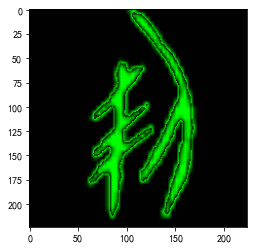

In [127]:
img_PIL_Tensor = train_ds[1][0]
new_img_PIL = transforms.ToPILImage()(img_PIL_Tensor).convert('RGB')
plt.imshow(new_img_PIL)
plt.show()
# print(new_img_PIL.show())

## 网络搭建

In [128]:
import torch.nn.functional as F
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1) # 按照公式计算后经过卷积层不改变尺寸
        self.pool = nn.MaxPool2d(2,2) # 2*2的池化 池化后size 减半
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
        
        
        self.fc1 = nn.Linear(16*56*56,256)#两个池化，所以是224/2/2=56
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,3)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
#         print("input:", x)
        x = self.pool(F.relu(self.conv1(x)))
#         print("first conv:", x)
        x = self.pool(F.relu(self.conv2(x)))
#         print("second conv:", x)
             
        x = x.view(-1, 16 * 56* 56)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x
        
   

### 预训练模型
除了自己手动DIY一个网络，也可以使用Pytorch已经提供的一些性能很好的模型比如VGG16，ResNet50等等，然后微调下网络结构，来得到符合自己的任务的网络架构。还可以直接下载这些模型在ImageNet上的预训练参数，然后在自己的数据集上进行训练。

我在这儿选择了ResNet50网络以及预训练好的权重进行了下实验，我在实验室的机器上面用P100跑的，因为自己的笔记本显卡太垃圾了只有2GB显存。

In [129]:
## 直接设置为True的话下载权重太慢了
## 所以手动用浏览器下载好了之后再重新加载
resnet50 = models.resnet152(pretrained=False)  
model_path = r"C:\dataset\guwen_new\files\resnet152-b121ed2d.pth"
resnet50.load_state_dict(torch.load(model_path))
resnet50.fc = nn.Linear(2048, 2) #修改最后一层网络将输出调整为两维

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



## 损失函数和优化函数

In [130]:
net = MyCNN()
# net = resnet50

In [131]:

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()  #二分类交叉熵损失函数
# criterion = nn.BCEWithLogitsLoss() #二分类交叉熵损失函数 带log loss
# criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)   

##  训练日志的打印

在之前的手写数字识别的准确率的计算和画图以日志的打印比较简单，在这更新为topk准确率以及使用tensorboard来画曲线。并且使用tqdm进度条来实时的打印日志。


专门建立一个类来保存和更新准确率的结果，使用类来让代码更加的规范化

In [132]:
class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

## 准确率的计算
torch.topk(input, k, dim=None, largest=True, sorted=True, out=None) -> (Tensor, LongTensor) 返回某一维度前k个的索引
input：一个tensor数据
k：指明是得到前k个数据以及其index
dim： 指定在哪个维度上排序， 默认是最后一个维度
largest：如果为True，按照大到小排序； 如果为False，按照小到大排序
sorted：返回的结果按照顺序返回
out：可缺省，不要

In [133]:
## topk的准确率计算
def accuracy(output, label, topk=(1,)):
    maxk = max(topk) 
    batch_size = label.size(0)
    
    # 获取前K的索引
    _, pred = output.topk(maxk, 1, True, True) #使用topk来获得前k个的索引
    pred = pred.t() # 进行转置
    # eq按照对应元素进行比较 view(1,-1) 自动转换到行为1,的形状， expand_as(pred) 扩展到pred的shape
    # expand_as 执行按行复制来扩展，要保证列相等
    correct = pred.eq(label.view(1, -1).expand_as(pred)) # 与正确标签序列形成的矩阵相比，生成True/False矩阵
#     print(correct)

    rtn = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0) # 前k行的数据 然后平整到1维度，来计算true的总个数
        rtn.append(correct_k.mul_(100.0 / batch_size)) # mul_() ternsor 的乘法  正确的数目/总的数目 乘以100 变成百分比
    return rtn

# tesnor 图片

In [134]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter('C:/dataset/guwen_new/files/')

## 迭代训练

In [135]:
import numpy as np
def train( epochs, train_loader, device, model, criterion, optimizer,tensorboard_path):
    model = model.to(device)
    top1_list=[]
    for epoch in range(epochs):
        train_loader = tqdm(train_loader)
        train_loss = 0.0
        model.train()
        top1 = AvgrageMeter()
        epoch_acc=[]
        train_loader.set_description('[%s%04d/%04d %s%f]' % ('Epoch:', epoch + 1, epochs, 'lr:', 0.001))
        for i, data in enumerate(train_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            # 初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs)
            #print(labels)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            #topk准确率
            prec1, prec2 = accuracy(outputs, labels, topk=(1, 2))
            n = inputs.size(0)
            top1.update(prec1.item(), n)
            train_loss += loss.item()
            postfix = {'train_loss': '%.6f' % (train_loss / (i + 1)), 'train_acc': '%.6f' % top1.avg}
            epoch_acc.append(top1.avg)
            #print(top1.avg)
            train_loader.set_postfix(log=postfix)
            # ternsorboard 曲线绘制
            writer = SummaryWriter(tensorboard_path)
            writer.add_scalar('Train/Loss', loss.item(), epoch)
            writer.add_scalar('Train/Accuracy', top1.avg, epoch)
            writer.flush()
        acc_epoch=np.mean(epoch_acc)
        top1_list.append(acc_epoch)
        print(top1)    
    print('Finished Training')
    return top1_list


##  模型评估
准确率验证
在验证集上面的验证，求网络的的准确率指标

In [136]:
def validate(validate_loader, device, model, criterion):
    val_acc = 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        val_top1 = AvgrageMeter()
        validate_loader = tqdm(validate_loader)
        validate_loss = 0.0
        for i, data in enumerate(validate_loader, 0):  # 0是下标起始位置默认为0
            inputs, labels = data[0].to(device), data[1].to(device)
            #         inputs,labels = data[0],data[1]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            prec1, prec2 = accuracy(outputs, labels, topk=(1, 2))
            n = inputs.size(0)
            val_top1.update(prec1.item(), n)
            validate_loss += loss.item()
            postfix = {'validate_loss': '%.6f' % (validate_loss / (i + 1)), 'validate_acc': '%.6f' % val_top1.avg}
            validate_loader.set_postfix(log=postfix)
        val_acc = val_top1.avg
    return val_acc

## 输出测试集的预测结果

In [137]:
def submission(csv_path,test_loader, device, model):
    result_list = []
    model = model.to(device)
    test_loader = tqdm(test_loader)
    with torch.no_grad():  # 进行评测的时候网络不更新梯度
        for i, data in enumerate(test_loader, 0):
            #print(images)
            #print(labels)
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            softmax_func = nn.Softmax(dim=1)  # dim=1表示行的和为1
            soft_output = softmax_func(outputs)
            predicted = soft_output[:, 1]
            for i in range(len(predicted)):
                result_list.append({
                    "id": labels[i].item(),
                    "label": predicted[i].item()
                })
    # 从list转成 dataframe 然后保存为csv文件
    columns = result_list[0].keys()
    result_dict = {col: [anno[col] for anno in result_list] for col in columns}
    result_df = pd.DataFrame(result_dict)
    result_df = result_df.sort_values("id")
    result_df.to_csv(csv_path, index=None)

## 完整调用流程


 损失函数和优化方法的确定

In [138]:
net = MyCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [139]:
import numpy as np
from sklearn.metrics import classification_report

def train(epochs, train_loader, device, model, criterion, optimizer, tensorboard_path):
    model = model.to(device)
    top1_list = []
    classes = ['Xiaozhuan', 'Jiagu','Jin']
    for epoch in range(epochs):
        train_loader = tqdm(train_loader)
        train_loss = 0.0
        model.train()
        top1 = AvgrageMeter()
        epoch_acc = []
        train_loader.set_description('[%s%04d/%04d %s%f]' % ('Epoch:', epoch + 1, epochs, 'lr:', 0.001))

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            prec1, prec2 = accuracy(outputs, labels, topk=(1, 2))
            #print(prec1)
            #print(prec2)
            n = inputs.size(0)
            metrics = calculate_metrics(outputs, labels)
            outputs = torch.argmax(outputs, dim=1)
            #print(outputs)
            #print(labels)
            # Update metrics here
              # This function should return a dictionary of metrics
            pre = classification_report(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), target_names=classes, digits=5)
            print(pre)
            top1.update(prec1.item(), n)
            train_loss += loss.item()
            postfix = {'train_loss': '%.6f' % (train_loss / (i + 1)), 'train_acc': '%.6f' % top1.avg}
            epoch_acc.append(top1.avg)
            train_loader.set_postfix(log=postfix)

            writer = SummaryWriter(tensorboard_path)
            writer.add_scalar('Train/Loss', loss.item(), epoch)
            writer.add_scalar('Train/Accuracy', top1.avg, epoch)

            # Log metrics to TensorBoard
            for key, value in metrics.items():
                writer.add_scalar('Train/' + key, value, epoch)

            writer.flush()
        print(metrics)
        acc_epoch = np.mean(epoch_acc)
        top1_list.append(acc_epoch)
        print(top1)

    print('Finished Training')
    return top1_list
def calculate_metrics(outputs, labels):
    predicted_labels = outputs.argmax(dim=1)
    correct_predictions = (predicted_labels == labels).float()

    # Calculate accuracy
    accuracy = correct_predictions.mean().item()

    # Calculate F1 score and recall using scikit-learn
    from sklearn.metrics import f1_score, recall_score

    f1 = f1_score(labels.cpu(), predicted_labels.cpu(), average='macro')
    recall = recall_score(labels.cpu(), predicted_labels.cpu(), average='macro')

    # Create a dictionary of metrics
    metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Recall': recall}

    return metrics

训练过程，需要传入epoch数目，训练数据加载器，设备，网络模型，损失函数，优化方法和tensorboard画图的路径等参数。
注意的是如果使用完整的官方训练数据集来训练网络后，用这个网络去在验证集上面验证是没有意义的，因为验证集的数据是从完整训练数据集上面划分出来，所以相当于在用训练数据验证性能。用划分过后的new_train_loader训练的网络在进行验证才有意义。

In [147]:
#train( 1, train_loader, device,net, criterion, optimizer,tensorboard_path) # 完整的训练数据集
allacc=train(15, new_train_loader, device,net, criterion, optimizer,tensorboard_path)
#划分80%后的训练数据集

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.90909   0.76923   0.83333        13
       Jiagu    0.60000   0.69231   0.64286        13
         Jin    0.50000   0.50000   0.50000         6

    accuracy                        0.68750        32
   macro avg    0.66970   0.65385   0.65873        32
weighted avg    0.70682   0.68750   0.69345        32

              precision    recall  f1-score   support

   Xiaozhuan    0.76471   1.00000   0.86667        13
       Jiagu    1.00000   0.75000   0.85714        12
         Jin    1.00000   0.85714   0.92308         7

    accuracy                        0.87500        32
   macro avg    0.92157   0.86905   0.88230        32
weighted avg    0.90441   0.87500   0.87543        32

              precision    recall  f1-score   support

   Xiaozhuan    0.44444   0.88889   0.59259         9
       Jiagu    0.60000   0.40000   0.48000        15
         Jin    0.75000   0.37500   0.50000         8

    accuracy        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.90000   0.81818   0.85714        11
       Jiagu    0.91667   0.73333   0.81481        15
         Jin    0.50000   0.83333   0.62500         6

    accuracy                        0.78125        32
   macro avg    0.77222   0.79495   0.76565        32
weighted avg    0.83281   0.78125   0.79377        32

              precision    recall  f1-score   support

   Xiaozhuan    0.78571   0.91667   0.84615        12
       Jiagu    0.69231   0.64286   0.66667        14
         Jin    0.40000   0.33333   0.36364         6

    accuracy                        0.68750        32
   macro avg    0.62601   0.63095   0.62549        32
weighted avg    0.67253   0.68750   0.67716        32

              precision    recall  f1-score   support

   Xiaozhuan    0.69231   0.81818   0.75000        11
       Jiagu    0.71429   0.83333   0.76923        12
         Jin    1.00000   0.55556   0.71429         9

    accuracy        

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.72222   1.00000   0.83871        13
       Jiagu    0.70000   0.77778   0.73684         9
         Jin    1.00000   0.40000   0.57143        10

    accuracy                        0.75000        32
   macro avg    0.80741   0.72593   0.71566        32
weighted avg    0.80278   0.75000   0.72653        32

              precision    recall  f1-score   support

   Xiaozhuan    0.72222   1.00000   0.83871        13
       Jiagu    0.90000   0.75000   0.81818        12
         Jin    1.00000   0.57143   0.72727         7

    accuracy                        0.81250        32
   macro avg    0.87407   0.77381   0.79472        32
weighted avg    0.84965   0.81250   0.80663        32

              precision    recall  f1-score   support

   Xiaozhuan    0.65000   1.00000   0.78788        13
       Jiagu    0.66667   0.54545   0.60000        11
         Jin    1.00000   0.37500   0.54545         8

    accuracy        

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.85714   0.92308   0.88889        13
       Jiagu    0.63636   0.87500   0.73684         8
         Jin    1.00000   0.63636   0.77778        11

    accuracy                        0.81250        32
   macro avg    0.83117   0.81148   0.80117        32
weighted avg    0.85106   0.81250   0.81268        32

              precision    recall  f1-score   support

   Xiaozhuan    0.68750   1.00000   0.81481        11
       Jiagu    0.70000   0.77778   0.73684         9
         Jin    1.00000   0.50000   0.66667        12

    accuracy                        0.75000        32
   macro avg    0.79583   0.75926   0.73944        32
weighted avg    0.80820   0.75000   0.73733        32

              precision    recall  f1-score   support

   Xiaozhuan    0.77778   1.00000   0.87500         7
       Jiagu    0.70000   0.70000   0.70000        10
         Jin    0.92308   0.80000   0.85714        15

    accuracy        

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.88889   0.66667   0.76190        12
       Jiagu    0.66667   1.00000   0.80000         6
         Jin    0.85714   0.85714   0.85714        14

    accuracy                        0.81250        32
   macro avg    0.80423   0.84127   0.80635        32
weighted avg    0.83333   0.81250   0.81071        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.87500   0.93333         8
       Jiagu    1.00000   0.80000   0.88889        10
         Jin    0.82353   1.00000   0.90323        14

    accuracy                        0.90625        32
   macro avg    0.94118   0.89167   0.90848        32
weighted avg    0.92279   0.90625   0.90627        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.85714   0.92308         7
       Jiagu    1.00000   0.58333   0.73684        12
         Jin    0.68421   1.00000   0.81250        13

    accuracy        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.85714   1.00000   0.92308         6
       Jiagu    1.00000   0.64286   0.78261        14
         Jin    0.75000   1.00000   0.85714        12

    accuracy                        0.84375        32
   macro avg    0.86905   0.88095   0.85428        32
weighted avg    0.87946   0.84375   0.83690        32

              precision    recall  f1-score   support

   Xiaozhuan    0.87500   1.00000   0.93333         7
       Jiagu    0.85714   0.85714   0.85714        14
         Jin    0.80000   0.72727   0.76190        11

    accuracy                        0.84375        32
   macro avg    0.84405   0.86147   0.85079        32
weighted avg    0.84141   0.84375   0.84107        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.92857   0.96296        14
       Jiagu    0.62500   0.83333   0.71429         6
         Jin    0.90909   0.83333   0.86957        12

    accuracy        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    0.88889   1.00000   0.94118         8
       Jiagu    0.93333   1.00000   0.96552        14
         Jin    1.00000   0.80000   0.88889        10

    accuracy                        0.93750        32
   macro avg    0.94074   0.93333   0.93186        32
weighted avg    0.94306   0.93750   0.93549        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.71429   0.83333         7
       Jiagu    0.64706   0.91667   0.75862        12
         Jin    0.90000   0.69231   0.78261        13

    accuracy                        0.78125        32
   macro avg    0.84902   0.77442   0.79152        32
weighted avg    0.82702   0.78125   0.78471        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.46154   0.63158        13
       Jiagu    0.68750   0.91667   0.78571        12
         Jin    0.60000   0.85714   0.70588         7

    accuracy        

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.93333   0.96552        15
       Jiagu    0.90000   0.90000   0.90000        10
         Jin    0.87500   1.00000   0.93333         7

    accuracy                        0.93750        32
   macro avg    0.92500   0.94444   0.93295        32
weighted avg    0.94141   0.93750   0.93800        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.90909   0.95238        11
       Jiagu    0.88889   0.80000   0.84211        10
         Jin    0.84615   1.00000   0.91667        11

    accuracy                        0.90625        32
   macro avg    0.91168   0.90303   0.90372        32
weighted avg    0.91239   0.90625   0.90564        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   0.90909   0.95238        11
       Jiagu    0.66667   0.85714   0.75000         7
         Jin    0.84615   0.78571   0.81481        14

    accuracy        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   1.00000   1.00000        12
       Jiagu    0.72727   0.88889   0.80000         9
         Jin    0.88889   0.72727   0.80000        11

    accuracy                        0.87500        32
   macro avg    0.87205   0.87205   0.86667        32
weighted avg    0.88510   0.87500   0.87500        32

              precision    recall  f1-score   support

   Xiaozhuan    0.80000   1.00000   0.88889        12
       Jiagu    1.00000   0.71429   0.83333         7
         Jin    0.91667   0.84615   0.88000        13

    accuracy                        0.87500        32
   macro avg    0.90556   0.85348   0.86741        32
weighted avg    0.89115   0.87500   0.87312        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   1.00000   1.00000         8
       Jiagu    1.00000   0.80000   0.88889        10
         Jin    0.87500   1.00000   0.93333        14

    accuracy        

  0%|          | 0/45 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   1.00000   1.00000         9
       Jiagu    1.00000   0.83333   0.90909        12
         Jin    0.84615   1.00000   0.91667        11

    accuracy                        0.93750        32
   macro avg    0.94872   0.94444   0.94192        32
weighted avg    0.94712   0.93750   0.93726        32

              precision    recall  f1-score   support

   Xiaozhuan    1.00000   1.00000   1.00000        11
       Jiagu    1.00000   1.00000   1.00000        11
         Jin    1.00000   1.00000   1.00000        10

    accuracy                        1.00000        32
   macro avg    1.00000   1.00000   1.00000        32
weighted avg    1.00000   1.00000   1.00000        32

              precision    recall  f1-score   support

   Xiaozhuan    0.91667   1.00000   0.95652        11
       Jiagu    0.90909   0.83333   0.86957        12
         Jin    0.88889   0.88889   0.88889         9

    accuracy        

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
#可视化训练结果
import plotly.graph_objects as go
epoch=list(range(1,121))
fig = go.Figure(data=go.Scatter(x=epoch, y=allacc, mode='lines+markers'))
fig.update_layout(title='准确率随Epoch变化', xaxis_title='Epoch', yaxis_title='准确率')
fig.show()

模型的保存和加载

In [33]:
torch.save(net.state_dict(), model_save_path)
val_net = MyCNN()
val_net.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [48]:
validate(validate_loader,device,val_net,criterion)

  0%|          | 0/12 [00:00<?, ?it/s]

64.68926553672317

输出测试集预测结果

In [35]:
test_loader